In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import networkx as nx
import pandas as pd
from torch_geometric.data import Data
import ast
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import RandomNodeSplit
from karateclub import Node2Vec

In [3]:
# Load edge information from edges.csv
edges_df = pd.read_csv('edges.csv')

# Load node information from nodes.csv
nodes_df = pd.read_csv('nodes.csv', index_col = 0)

In [3]:
edges_df

,Unnamed: 0,sourceNodeId,targetNodeId,relationshipType
0,0,35,1033,CITES
1,1,35,103482,CITES
2,2,35,103515,CITES
3,3,35,1050679,CITES
4,4,35,1103960,CITES
...,...,...,...,...
10551,5423,853155,853115,CITES
10552,5425,853155,853116,CITES
10553,5426,1140289,853118,CITES
10554,5427,853118,853155,CITES


In [4]:
nodes_df

,nodeId,labels,subject,features
0,31336,Paper,Neural_Networks,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1061127,Paper,Rule_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,1106406,Paper,Reinforcement_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,13195,Paper,Reinforcement_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,37879,Paper,Probabilistic_Methods,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
2703,1128975,Paper,Genetic_Algorithms,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2704,1128977,Paper,Genetic_Algorithms,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2705,1128978,Paper,Genetic_Algorithms,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2706,117328,Paper,Case_Based,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
nodes = nodes_df.drop(['labels'], axis=1)
labels = nodes["subject"]
features = nodes["features"].apply(ast.literal_eval).apply(lambda x: np.array(x, dtype=np.float32))
feature_tensor = torch.tensor(features.tolist(), dtype=torch.float32)

/var/folders/4p/y01p6zrx4351k0kmzl85g7r80000gn/T/ipykernel_90993/3446413232.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  feature_tensor = torch.tensor(features.tolist(), dtype=torch.float32)


In [5]:
#create new id mapping for nodes (to be in range [0,2708])
NODE_ID_MAPPING = {}
for i, nid in nodes_df["nodeId"].items():
    #print(i, nid)
    NODE_ID_MAPPING[nid] = i

In [6]:
#apply id mapping to edges
edges_df["mapped_source"] = edges_df["sourceNodeId"].apply(lambda x: NODE_ID_MAPPING[x])
edges_df["mapped_target"] = edges_df["targetNodeId"].apply(lambda x: NODE_ID_MAPPING[x])
edges_df.head()

edges = edges_df[['mapped_source', 'mapped_target']].values.T

In [7]:
edges

array([[ 163,  163,  163, ..., 2258, 1887, 1686],
       [ 402,  659, 1696, ..., 1887, 1902,  837]])

In [8]:
# Convert labels to numerical encoding
label_mapping = {label: i for i, label in enumerate(set(labels))}
#numerical_labels = [label_mapping[label] for label in labels]
numerical_labels = labels.apply(lambda x: label_mapping[x])

In [9]:
numerical_labels

0       6
1       0
2       3
3       3
4       1
       ..
2703    5
2704    5
2705    5
2706    4
2707    6
Name: subject, Length: 2708, dtype: int64

In [10]:
G=nx.Graph()

In [11]:
G.add_edges_from(edges.T)

In [12]:
nodes

,nodeId,subject,features
0,31336,Neural_Networks,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1061127,Rule_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,1106406,Reinforcement_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,13195,Reinforcement_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,37879,Probabilistic_Methods,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
2703,1128975,Genetic_Algorithms,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2704,1128977,Genetic_Algorithms,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2705,1128978,Genetic_Algorithms,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2706,117328,Case_Based,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
G.edges

EdgeView([(163, 402), (163, 659), (163, 1696), (163, 2295), (163, 1274), (163, 1286), (163, 1544), (163, 2600), (163, 2363), (163, 1905), (163, 1611), (163, 141), (163, 1807), (163, 1110), (163, 174), (163, 2521), (163, 1792), (163, 1675), (163, 1334), (163, 813), (163, 1799), (163, 1943), (163, 2077), (163, 765), (163, 769), (163, 781), (163, 940), (163, 942), (163, 1590), (163, 1734), (163, 1872), (163, 2286), (163, 390), (163, 1717), (163, 1030), (163, 2274), (163, 2518), (163, 606), (163, 800), (163, 1575), (163, 546), (163, 1070), (163, 309), (163, 935), (163, 1205), (163, 1571), (163, 1971), (163, 1127), (163, 530), (163, 856), (163, 2604), (163, 910), (163, 2173), (163, 191), (163, 1253), (163, 1728), (163, 1729), (163, 1206), (163, 2177), (163, 1136), (163, 1457), (163, 2265), (163, 1225), (163, 2563), (163, 1689), (163, 1498), (163, 563), (163, 2396), (163, 717), (163, 1890), (163, 188), (163, 982), (163, 1130), (163, 55), (163, 346), (163, 2673), (163, 1379), (163, 1380), (16

In [14]:
for node in nodes.iterrows():
    nodeId = node[1]["nodeId"]
    nodeSubject= node[1]["subject"]
    index = NODE_ID_MAPPING[nodeId]
    G.nodes[index]['label']= nodeSubject
    

In [15]:
for ind, lab in numerical_labels.items():
    G.nodes[ind]["label"] = lab

In [16]:
G.nodes[1]

{'label': 0}

In [17]:
node2vec= Node2Vec(p=0.5, q=2, walk_length=25, window_size=5)
embeddings = node2vec.fit(G)

In [18]:
node2vec.get_embedding()

array([[-0.91194713, -0.5170728 ,  0.15727377, ..., -0.17808986,
         0.3943936 ,  0.5932446 ],
       [ 0.2815852 , -0.2779374 , -0.68522215, ..., -0.25427806,
        -0.54026735, -0.5032662 ],
       [ 0.33208683, -0.7773054 , -0.19581391, ..., -0.01487944,
         0.29123262, -1.3165497 ],
       ...,
       [-0.51574326,  0.00294158, -0.4951807 , ...,  0.30026236,
        -0.88149536, -1.2674139 ],
       [-1.0459577 ,  0.73253113, -0.05958924, ...,  0.11342403,
        -0.16408949,  1.4220405 ],
       [-0.55374   , -0.20598248,  0.18817745, ...,  0.29530126,
         0.2448303 , -0.06620833]], dtype=float32)

In [73]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [20]:
X_train, X_test, y_train, y_test = train_test_split(node2vec.get_embedding(), numerical_labels.values, train_size=0.7,random_state=42)

In [21]:
numerical_labels.values

array([6, 0, 3, ..., 5, 4, 6])

In [22]:
classifier = LogisticRegression(max_iter=300)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [23]:
y_pred=classifier.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, y_pred)

In [25]:
accuracy

0.6715867158671587

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [28]:
y_pred = knn.predict(X_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [29]:
accuracy = accuracy_score(y_test, y_pred)

In [30]:
accuracy

0.6888068880688807

In [31]:
X_test

array([[-0.38678816, -0.07303906, -0.66606796, ..., -0.03804732,
        -0.2196952 , -0.642842  ],
       [ 0.2905778 ,  0.48581418, -0.82990366, ...,  1.2934551 ,
         0.41810855, -0.52439064],
       [-0.37050748,  0.2592494 ,  0.48441234, ..., -0.20749317,
        -0.3286558 ,  0.34426343],
       ...,
       [ 0.48753422,  0.12671842, -0.18338168, ...,  0.7975499 ,
         0.8040185 ,  0.7514152 ],
       [-0.18017066, -0.17156772,  0.1886277 , ...,  0.48610035,
        -0.35187286, -0.7666865 ],
       [ 0.1582229 , -0.20084797,  0.06066597, ...,  0.05665577,
         0.11632599, -0.15888865]], dtype=float32)

In [32]:
y_test

array([6, 6, 5, 2, 5, 4, 4, 2, 5, 4, 5, 6, 2, 6, 6, 6, 2, 5, 1, 6, 6, 4,
       2, 0, 5, 6, 4, 4, 2, 1, 6, 5, 4, 6, 6, 2, 1, 2, 6, 6, 1, 6, 1, 5,
       6, 5, 1, 1, 5, 5, 4, 4, 5, 0, 1, 4, 2, 6, 6, 2, 6, 6, 3, 5, 5, 6,
       1, 1, 3, 6, 1, 1, 6, 0, 6, 6, 1, 6, 6, 1, 6, 0, 1, 3, 1, 1, 4, 0,
       6, 1, 5, 5, 0, 2, 4, 1, 4, 3, 5, 4, 4, 2, 6, 6, 6, 6, 4, 1, 6, 6,
       5, 1, 1, 1, 6, 1, 1, 2, 1, 5, 3, 2, 5, 1, 5, 5, 6, 6, 5, 6, 1, 2,
       3, 6, 3, 2, 6, 6, 0, 6, 6, 5, 5, 6, 3, 6, 1, 6, 5, 6, 6, 6, 1, 1,
       5, 6, 6, 1, 5, 0, 3, 3, 1, 3, 2, 1, 6, 1, 2, 2, 2, 5, 2, 3, 2, 5,
       0, 4, 4, 0, 2, 4, 6, 4, 6, 1, 1, 6, 2, 2, 0, 4, 5, 6, 6, 2, 2, 4,
       3, 5, 6, 1, 6, 6, 0, 1, 3, 0, 1, 1, 2, 2, 6, 2, 5, 1, 2, 2, 1, 2,
       1, 4, 1, 1, 0, 1, 6, 1, 3, 4, 2, 6, 0, 2, 3, 1, 4, 5, 5, 6, 4, 2,
       1, 5, 6, 6, 1, 3, 0, 6, 3, 2, 1, 6, 1, 6, 0, 4, 6, 2, 2, 6, 0, 6,
       5, 6, 5, 6, 6, 5, 6, 5, 1, 2, 5, 4, 6, 1, 5, 0, 2, 5, 2, 2, 5, 5,
       2, 6, 2, 6, 3, 1, 5, 3, 5, 4, 6, 6, 1, 6, 6,

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


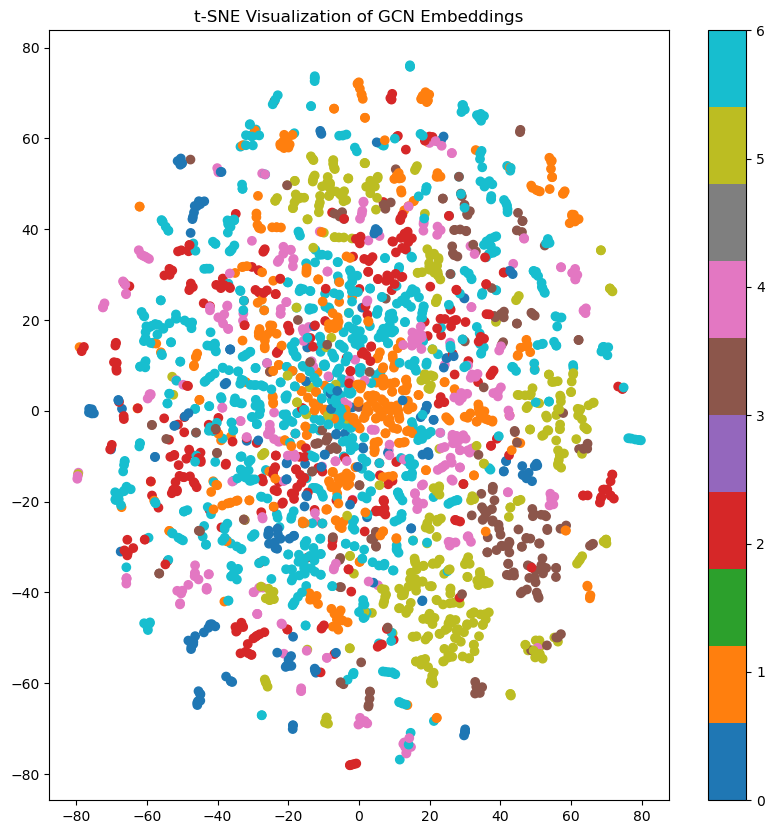

In [34]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming you have the GCN embeddings stored in a variable called "embeddings"
# Shape of "embeddings": (num_samples, embedding_dim)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(node2vec.get_embedding())

# Assuming you have the ground truth labels stored in a variable called "labels"
# Shape of "labels": (num_samples,)

# Plot the t-SNE representation with colored labels
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=numerical_labels, cmap='tab10')
plt.title("t-SNE Visualization of GCN Embeddings")
plt.colorbar()
plt.show()